# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [ ]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

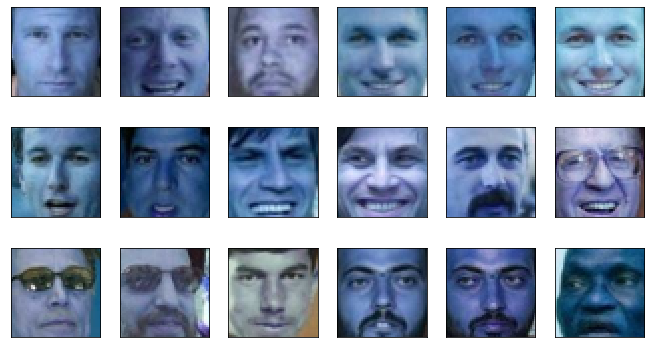

In [ ]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [64]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.models import Sequential
from keras import layers as L
from tensorflow.keras.models import Model

dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# here I followed the idea Tensorflow Autoencoder tutorial with adaptation to your comments

initializer = tf.keras.initializers.GlorotNormal()

class Autoencoder(Model):
    def __init__(self, dimZ):
        super(Autoencoder, self).__init__()
        self.dimZ = dimZ   
        
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape=X_train.shape[1]),
                                        layers.Dense(2 * dimZ, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
                                        layers.Dense(dimZ, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),])
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=dimZ),
                                        layers.Dense(2 * dimZ, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
                                        layers.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=initializer, bias_initializer='zeros')])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(dimZ)

In [65]:
# Create MSE loss function
# Use Adam optimizer

from tensorflow.keras import losses
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [66]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/10
313/313 [==============================] - 3s 7ms/step - loss: 0.0230 - val_loss: 0.0140
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 9/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 10/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0059

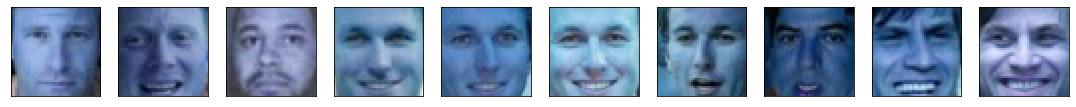

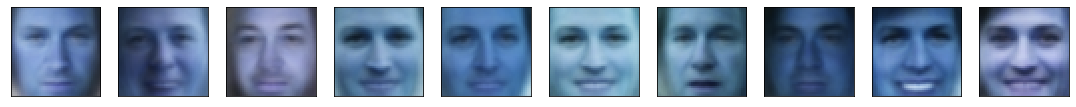

In [ ]:
# Examine the reconstructions

def plot_gallery_2(images, h, w, n_row=1, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

# Examine the reconstructions
encoded_imgs = autoencoder.encoder(X_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot_gallery_2(X_train[:18], image_h, image_w)

plot_gallery_2(decoded_imgs[:18], image_h, image_w)

Reconstruction is not bad, right?

#### yep, reconstructions are not very bad. 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

In [ ]:
z = np.random.randn(25, dimZ)*0.5

print(z.shape)
# output = None # FIXME compute from decoder from z

# just simply giving this z to the autoencoder.decoder
output = autoencoder.decoder(z).numpy()

output

# plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

(25, 100)


array([[0.18645811, 0.21584636, 0.23149528, ..., 0.28168398, 0.35536104,
        0.4330874 ],
       [0.24954136, 0.2991823 , 0.3420284 , ..., 0.30763918, 0.30211705,
        0.38172686],
       [0.19067703, 0.20684955, 0.19195962, ..., 0.24802464, 0.30536804,
        0.31705433],
       ...,
       [0.27401897, 0.31144476, 0.34480235, ..., 0.21599306, 0.22757062,
        0.244231  ],
       [0.3365434 , 0.33485648, 0.3323552 , ..., 0.31356508, 0.33434603,
        0.44985813],
       [0.39547464, 0.41891912, 0.42010534, ..., 0.3271439 , 0.34377885,
        0.36787027]], dtype=float32)

In [ ]:
# nice! this is very interesting! 

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

#### Depends on the encoder itself, huh? If we deal with an ideal encoder/decoder - than yep, but we understand, that this is possible only in theory

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [1]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

(10000, 6075)
(3143, 6075)


In [2]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.models import Sequential
from keras import layers as L
from tensorflow.keras.models import Model
import keras
from keras import backend as K 

K.clear_session()

initializer = tf.keras.initializers.GlorotNormal()

class VarAutoencoder(Model):
    def __init__(self, dimZ):
        super(VarAutoencoder, self).__init__()
        self.dimZ = dimZ   
        
        self.encoder = tf.keras.Sequential([ layers.InputLayer(input_shape=X_train.shape[1]),
                                        layers.Dense(8 * dimZ, activation='relu'),
                                        # layers.BatchNormalization(),
                                        layers.Dense(2 * dimZ , activation='relu' ),
                                        # layers.BatchNormalization()
                                        ])
        
        self.decoder = tf.keras.Sequential([ layers.InputLayer(input_shape=dimZ),
                                        layers.Dense(8 * dimZ, activation='relu'),
                                        # layers.BatchNormalization(),
                                        layers.Dense(X_train.shape[1], activation='sigmoid' ),
                                        # layers.BatchNormalization()
                                        ])
    
    def encode(self, x):  # returns the same mean, logvar
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):  # returns the same
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * logvar) * epsilon

    def decode(self, z):
        return self.decoder(z)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [3]:
def KL_divergence(z_mean, z_log_var):
  kld = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
  kld = tf.reduce_mean(tf.reduce_sum(kld, axis=1))
  return kld

def log_likelihood(x, decoded_x):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(x, decoded_x)))
  # print(reconstructions_loss)
  return reconstruction_loss

def loss_vae(x, decoded_x, z_mean, z_log_var):
  kld = KL_divergence(z_mean, z_log_var)
  loglike = log_likelihood(x, decoded_x)
  return -kld + loglike

# here I wasted at least two days trying to train a with log likelihood loss defined above but hadn't succeeded. 
# hence switched to simple binary crossentropy so that my decoder gives z not probability. seems that this worked

And train the model:

In [5]:
# train your autoencoder

def train_step(mmmodel, x, ooptimizer):
    with tf.GradientTape() as tape:
      mean, logvar = mmmodel.encode(x)
      # print(KL_divergence(mean, logvar))
      
      z = mmmodel.reparameterize(mean, logvar)
      
      decoded_x = mmmodel.decode(z)
      # print(log_likelihood(x, decoded_x))
      
      loss = loss_vae(x, decoded_x, mean, logvar)
    gradients = tape.gradient(loss, mmmodel.trainable_weights)
    # print(gradients)
    optimizer.apply_gradients(zip(gradients, mmmodel.trainable_weights))
    return loss

In [6]:
# training

varautoencoder = VarAutoencoder(dimZ)
optimizer = keras.optimizers.Adam(learning_rate=0.005)

for i in range(1500):
  loss_train = train_step(varautoencoder, X_train, optimizer)
  if i %100==0:
    print('epoch:', i, "|", 'train loss:', loss_train.numpy())

epoch: 0 | train loss: 6966.811
epoch: 100 | train loss: 6745.55
epoch: 200 | train loss: 6625.773
epoch: 300 | train loss: 6592.5137
epoch: 400 | train loss: 6577.9683
epoch: 500 | train loss: 6574.8794
epoch: 600 | train loss: 6573.235
epoch: 700 | train loss: 6570.994
epoch: 800 | train loss: 6570.1904
epoch: 900 | train loss: 6569.8477
epoch: 1000 | train loss: 6569.805
epoch: 1100 | train loss: 6569.7227
epoch: 1200 | train loss: 6569.1577
epoch: 1300 | train loss: 6568.775
epoch: 1400 | train loss: 6568.64


In [8]:
# test your autoencoder with validation data
mean_val, logvar_val = varautoencoder.encode(X_val)
z_val = varautoencoder.reparameterize(mean_val, logvar_val)
decoded_x_val = varautoencoder.decode(z_val)

print('loss_val:', loss_vae(X_val, decoded_x_val, mean_val, logvar_val).numpy())

loss_val: 2059.5293


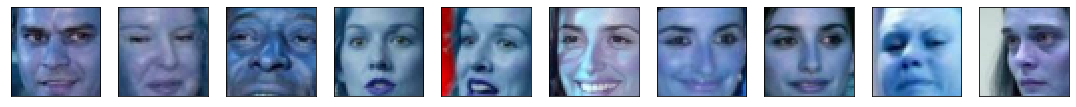

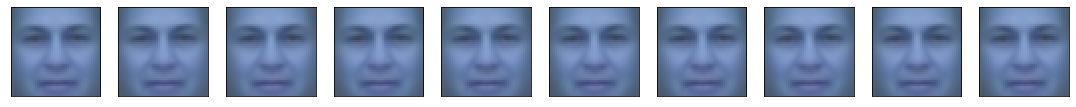

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_gallery_3(images, h, w, n_row=1, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(tf.reshape(images[i], (h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

plot_gallery_3(X_val[:18], image_h, image_w)
plot_gallery_3(decoded_x_val[:18], image_h, image_w)

In [ ]:
# hm, this is my result. i've played a LOOOOT with learning rates, epochs (training for an hour, for example), etc. but still am receiving this type of pics. 
# researched a bit and seems that this is not a bad result

And finally sample from VAE.

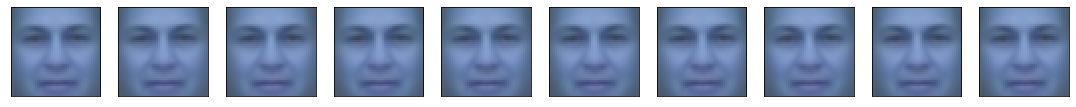

In [11]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = np.random.randn(25, dimZ)*0.5
decoded_x_sample = varautoencoder.decode(z_val)

plot_gallery_3(decoded_x_sample, image_h, image_w, n_row=1, n_col=10)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

In [ ]:
# ok, got the idea. in fact played a lot with this VAE as first it wasn't learning anything, then when finally started learning something I got this ;)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

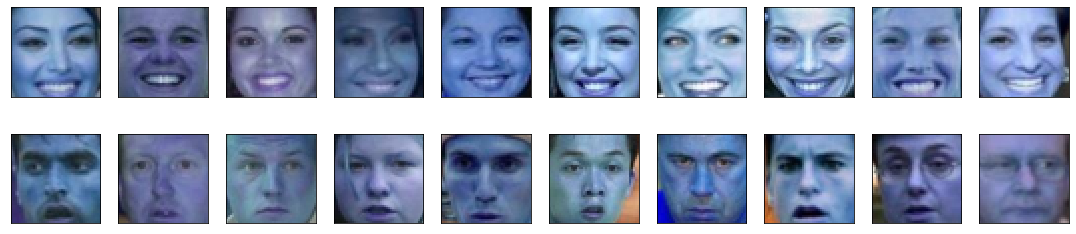

In [23]:
# 1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

smiling_attribute = attrs.Smiling.values # extract
smiling_atribute_sorted = np.argsort(smiling_attribute) # sort it

plot_gallery_3(np.vstack((data[smiling_atribute_sorted[-10:]], data[smiling_atribute_sorted[:10]])), image_h, image_w, n_row=2, n_col=10) # plot it

In [30]:
# 2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found "vector representation" of the "smile" and "no smile" attribute.

smiling = data[smiling_atribute_sorted[-10:]]
not_smiling = data[smiling_atribute_sorted[:10]]

smiling = smiling.reshape((10, -1))
smiling = np.float32(smiling)
smiling = smiling/255

not_smiling = not_smiling.reshape((10, -1))
not_smiling = np.float32(not_smiling)
not_smiling = not_smiling/255

smiling.shape

(10, 6075)

In [77]:
latent_smile = []
latent_nosmile = []

for i in smiling:
  mean_sm, logvar_sm = varautoencoder.encode(smiling)
  z_sm = varautoencoder.reparameterize(mean_sm, logvar_sm)
  latent_smile.append(z_sm.numpy())

for i in not_smiling:
  mean_nsm, logvar_nsm = varautoencoder.encode(not_smiling)
  z_nsm = varautoencoder.reparameterize(mean_nsm, logvar_nsm)
  latent_nosmile.append(z_nsm.numpy())

latent_smile = np.mean(latent_smile, axis = 1)
latent_nosmile = np.mean(latent_nosmile, axis = 1)

In [78]:
# 3) Compute the difference: "smile" vector minus "non-smile" vector.

smile_vector = (latent_smile - latent_nosmile)

In [ ]:
# 3) Now check if "feature arithmetics" works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

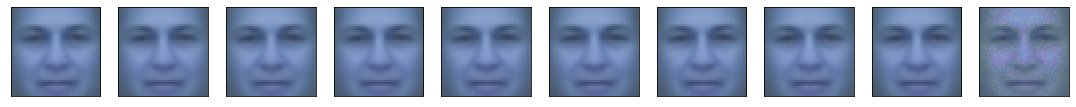

In [79]:
# vae

meanns, logvarns = varautoencoder.encode(not_smiling)
zns = varautoencoder.reparameterize(meanns, logvarns)

decoded_xns = varautoencoder.decode(zns + smile_vector)

plot_gallery_3(decoded_xns, image_h, image_w, n_row=1, n_col=10)

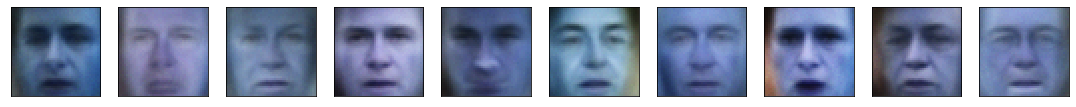

In [80]:
# autoencoder

encoded_imgs = autoencoder.encoder(not_smiling).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs + smile_vector).numpy()

plot_gallery_3(decoded_imgs, image_h, image_w, n_row=1, n_col=10)

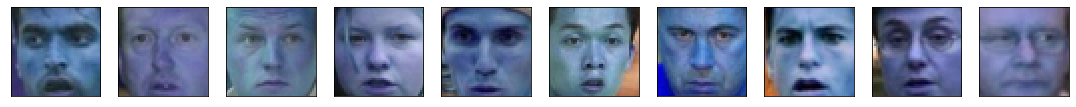

In [76]:
plot_gallery_3((data[smiling_atribute_sorted[:10]]), image_h, image_w, n_row=1, n_col=10) # plot it

In [ ]:
# difficult to say if this smile vector works. however, as of huge number of tries I got the idea of autoencoders and vae's/
# probably at some time point will dive deeper into this theory and algorithm, improve it